In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA


In [2]:
## making dictionary to find blacklist pair between train and test dataset
bl_match = np.loadtxt('data/bl_matching_dev.csv',dtype='str')
dev2train={}
dev2id={}
train2dev={}
train2id={}
for iter, line in enumerate(bl_match):
    line_s = line.split(',')
    dev2train[line_s[1].split('_')[-1]]= line_s[2].split('_')[-1]
    dev2id[line_s[1].split('_')[-1]]= line_s[0].split('_')[-1]
    train2dev[line_s[2].split('_')[-1]]= line_s[1].split('_')[-1]
    train2id[line_s[2].split('_')[-1]]= line_s[0].split('_')[-1]
    

In [3]:
def load_ivector(filename):
    utt = np.loadtxt(filename,dtype='str',delimiter=',',skiprows=1,usecols=[0])
    ivector = np.loadtxt(filename,dtype='float32',delimiter=',',skiprows=1,usecols=range(1,601))
    spk_id = []
    for iter in range(len(utt)):
        spk_id = np.append(spk_id,utt[iter].split('_')[0])

    return spk_id, utt, ivector

def length_norm(mat):
# length normalization (l2 norm)
# input: mat = [utterances X vector dimension] ex) (float) 8631 X 600

    norm_mat = []
    for line in mat:
        temp = line/np.math.sqrt(sum(np.power(line,2)))
        norm_mat.append(temp)
    norm_mat = np.array(norm_mat)
    return norm_mat

def make_spkvec(mat, spk_label):
# calculating speaker mean vector
# input: mat = [utterances X vector dimension] ex) (float) 8631 X 600
#        spk_label = string vector ex) ['abce','cdgd']

#     for iter in range(len(spk_label)):
#         spk_label[iter] = spk_label[iter].split('_')[0]

    spk_label, spk_index  = np.unique(spk_label,return_inverse=True)
    spk_mean=[]
    mat = np.array(mat)

    # calculating speaker mean i-vector
    for i, spk in enumerate(spk_label):
        spk_mean.append(np.mean(mat[np.nonzero(spk_index==i)],axis=0))
    spk_mean = length_norm(spk_mean)
    return spk_mean, spk_label

def calculate_EER(trials, scores):
# calculating EER of Top-S detector
# input: trials = boolean(or int) vector, 1: postive(blacklist) 0: negative(background)
#        scores = float vector

    # Calculating EER
    fpr,tpr,threshold = roc_curve(trials,scores,pos_label=1)
    fnr = 1-tpr
    EER_threshold = threshold[np.argmin(abs(fnr-fpr))]
    
    #plot auc
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1)
    plt.show()
    
    # print EER_threshold
    EER_fpr = fpr[np.argmin(np.absolute((fnr-fpr)))]
    EER_fnr = fnr[np.argmin(np.absolute((fnr-fpr)))]
    EER = 0.5 * (EER_fpr+EER_fnr)
    
    print ("Top S detector EER is %0.2f%%"% (EER*100))
    return EER

def get_trials_label_with_confusion(identified_label, groundtruth_label,dict4spk,is_trial ):
# determine if the test utterance would make confusion error
# input: identified_label = string vector, identified result of test utterance among multi-target from the detection system 
#        groundtruth_label = string vector, ground truth speaker labels of test utterances
#        dict4spk = dictionary, convert label to target set, ex) train2dev convert train id to dev id

    trials = np.zeros(len(identified_label))
    for iter in range(0,len(groundtruth_label)):
        enroll = identified_label[iter].split('_')[0]
        test = groundtruth_label[iter].split('_')[0]
        if is_trial[iter]:
            if enroll == dict4spk[test]:
                trials[iter]=1 # for Target trial (blacklist speaker)
            else:
                trials[iter]=-1 # for Target trial (backlist speaker), but fail on blacklist classifier
                
        else :
            trials[iter]=0 # for non-target (non-blacklist speaker)
    return trials

def calculate_EER_with_confusion(scores,trials):
# calculating EER of Top-1 detector
# input: trials = boolean(or int) vector, 1: postive(blacklist) 0: negative(background) -1: confusion(blacklist)
#        scores = float vector

    # exclude confusion error (trials==-1)
    scores_wo_confusion = scores[np.nonzero(trials!=-1)[0]]
    trials_wo_confusion = trials[np.nonzero(trials!=-1)[0]]

    # dev_trials contain labels of target. (target=1, non-target=0)
    fpr,tpr,threshold = roc_curve(trials_wo_confusion,scores_wo_confusion,pos_label=1, drop_intermediate=False)
    fnr = 1-tpr
    EER_threshold = threshold[np.argmin(abs(fnr-fpr))]
    
    # EER withouth confusion error
    EER = fpr[np.argmin(np.absolute((fnr-fpr)))]
    
    # Add confusion error to false negative rate(Miss rate)
    total_negative = len(np.nonzero(np.array(trials_wo_confusion)==0)[0])
    total_positive = len(np.nonzero(np.array(trials_wo_confusion)==1)[0])
    fp= fpr*np.float(total_negative)  
    fn= fnr*np.float(total_positive) 
    fn += len(np.nonzero(trials==-1)[0])
    total_positive += len(np.nonzero(trials==-1)[0])
    fpr= fp/total_negative
    fnr= fn/total_positive

    # EER with confusion Error
    EER_threshold = threshold[np.argmin(abs(fnr-fpr))]
    EER_fpr = fpr[np.argmin(np.absolute((fnr-fpr)))]
    EER_fnr = fnr[np.argmin(np.absolute((fnr-fpr)))]
    EER = 0.5 * (EER_fpr+EER_fnr)
    
    print ("Top 1 detector EER is %0.2f%% (Total confusion error is %d)"% ((EER*100), len(np.nonzero(trials==-1)[0])))
    return EER

# Loading i-vector
trn_bl_id, trn_bl_utt, trn_bl_ivector = load_ivector('data/trn_blacklist.csv')
trn_bg_id, trn_bg_utt, trn_bg_ivector = load_ivector('data/trn_background.csv')
dev_bl_id, dev_bl_utt, dev_bl_ivector = load_ivector('data/dev_blacklist.csv')
dev_bg_id, dev_bg_utt, dev_bg_ivector = load_ivector('data/dev_background.csv')

# Calculating speaker mean vector
#spk_mean, spk_mean_label = make_spkvec(trn_bl_ivector,trn_bl_id)


In [4]:
#length normalization
trn_bl_ivector = length_norm(trn_bl_ivector)
trn_bg_ivector = length_norm(trn_bg_ivector)
dev_bl_ivector = length_norm(dev_bl_ivector)
dev_bg_ivector = length_norm(dev_bg_ivector)
#spk_mean = length_norm(spk_mean)


print ('\nDev set score using train set :')
# making trials of Dev set
dev_ivector = np.append(dev_bl_ivector, dev_bg_ivector,axis=0)
dev_trials = np.append(np.ones([len(dev_bl_id), 1]), np.zeros([len(dev_bg_id), 1]))

# making trials of Trn set
trn_ivector = np.append(trn_bl_ivector, trn_bg_ivector,axis=0)
trn_trials = np.append(np.ones([len(trn_bl_id), 1]), np.zeros([len(trn_bg_id), 1]))

#making total ivector and trial of Trn + Dev set
total_ivector = np.append(trn_ivector,dev_ivector,axis=0)
total_trials = np.append(trn_trials, dev_trials)



Dev set score using train set :


In [5]:
## making total blacklist set
total_bl_ivector = np.append(trn_bl_ivector, dev_bl_ivector,axis=0)
#total_bl_ivector = length_norm(total_bl_ivector)
#print(trn_bl_id)

#print(dev2train.get(dev_bl_id))
#total_bl_id = np.append(trn_bl_id, dev2train.get(dev_bl_id))
values = []
for k in dev_bl_id:
    value = dev2train.get(k)
    values.append(value)
#print(len(values))
total_bl_id = np.append(trn_bl_id, values)
print(len(total_bl_id))


14524


In [6]:
# Calculating speaker mean vector
spk_mean, spk_mean_label = make_spkvec(total_bl_ivector,total_bl_id) 
#print(len(spk_mean))
#print(spk_mean)
#print(len(spk_mean_label))
#print(spk_mean_label)

In [7]:
# lda 
ldamodule1 = LDA(n_components=600) # 300 350 400 450
#ldamodule1.fit(np.asarray(trn_bl_ivector),np.asarray(trn_bl_id))
ldamodule1.fit(np.asarray(total_bl_ivector),np.asarray(total_bl_id))
model_ivec = ldamodule1.transform(np.asarray(spk_mean))
test_ivec = ldamodule1.transform(np.asarray(dev_ivector))
#trn_bl_ivector = ldamodule1.transform(np.asarray(trn_bl_ivector))
total_bl_ivector = ldamodule1.transform(np.asarray(total_bl_ivector))

#model_ivec =std_scale(model_ivec)
#test_ivec =std_scale(test_ivec)
#trn_bl_ivector =std_scale(trn_bl_ivector)

model_ivec = length_norm(model_ivec)
test_ivec = length_norm(test_ivec)
#trn_bl_ivector = length_norm(trn_bl_ivector)
total_bl_ivector = length_norm(total_bl_ivector)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


[ 9.86611978 11.51033454 13.76611106 ...  3.45753464  2.59876505
  2.2101593 ]


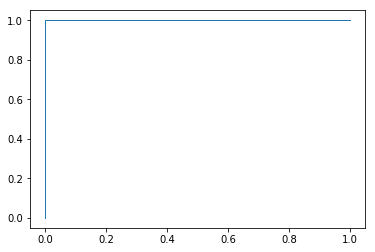

Top S detector EER is 0.00%
Top 1 detector EER is 0.00% (Total confusion error is 0)


In [8]:
# Cosine distance scoring
scores = model_ivec.dot(test_ivec.transpose())

# Multi-target normalization
#blscores = model_ivec.dot(trn_bl_ivector.transpose())
blscores = model_ivec.dot(total_bl_ivector.transpose())
mnorm_mu = np.mean(blscores,axis=1)
mnorm_std = np.std(blscores,axis=1)
for iter in range(np.shape(scores)[1]):
    scores[:,iter]= (scores[:,iter] - mnorm_mu) / mnorm_std

dev_scores = np.max(scores,axis=0)
print(dev_scores)
dev_EER = calculate_EER(dev_trials, dev_scores)


#divide trial label into target and non-target, plus confusion error(blacklist, fail at blacklist detector)
dev_identified_label = spk_mean_label[np.argmax(scores,axis=0)]
dev_trials_label = np.append( dev_bl_id,dev_bg_id)
dev_trials_utt_label = np.append( dev_bl_utt,dev_bg_utt)

# Top-1 detector EER
dev_trials_confusion = get_trials_label_with_confusion(dev_identified_label, dev_trials_label, dev2train, dev_trials )
dev_EER_confusion = calculate_EER_with_confusion(dev_scores,dev_trials_confusion)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


[15.56723705 15.38871861 17.43725972 ...  3.6023937   3.16344589
  2.64323295]


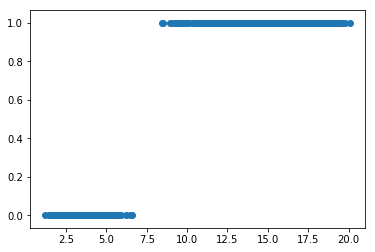

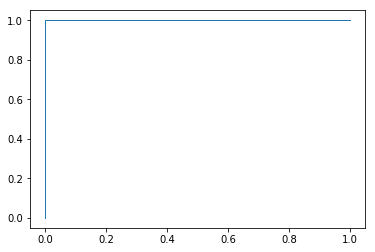

Top S detector EER is 0.00%
Top 1 detector EER is 0.00% (Total confusion error is 0)


In [9]:
# lda 
ldamodule1 = LDA(n_components=600)
#ldamodule1.fit(np.asarray(trn_bl_ivector),np.asarray(trn_bl_id))
ldamodule1.fit(np.asarray(total_bl_ivector),np.asarray(total_bl_id))
model_ivec = ldamodule1.transform(np.asarray(spk_mean))
test_ivec = ldamodule1.transform(np.asarray(dev_ivector))
trn_bl_ivector = ldamodule1.transform(np.asarray(trn_bl_ivector))
total_bl_ivector = ldamodule1.transform(np.asarray(total_bl_ivector))

#model_ivec =std_scale(model_ivec)
#test_ivec =std_scale(test_ivec)
#trn_bl_ivector =std_scale(trn_bl_ivector)

model_ivec = length_norm(model_ivec)
test_ivec = length_norm(test_ivec)
trn_bl_ivector = length_norm(trn_bl_ivector)
total_bl_ivector = length_norm(total_bl_ivector)

# Cosine distance scoring
scores = model_ivec.dot(test_ivec.transpose())

# Multi-target normalization
#blscores = model_ivec.dot(trn_bl_ivector.transpose())
blscores = model_ivec.dot(total_bl_ivector.transpose())
mnorm_mu = np.mean(blscores,axis=1)
mnorm_std = np.std(blscores,axis=1)
for iter in range(np.shape(scores)[1]):
    scores[:,iter]= (scores[:,iter] - mnorm_mu) / mnorm_std
dev_scores = np.max(scores,axis=0)
print(dev_scores)

plt.scatter(dev_scores,dev_trials)
plt.show()

# Top-S detector EER
dev_EER = calculate_EER(dev_trials, dev_scores)

#divide trial label into target and non-target, plus confusion error(blacklist, fail at blacklist detector)
dev_identified_label = spk_mean_label[np.argmax(scores,axis=0)]
dev_trials_label = np.append( dev_bl_id,dev_bg_id)
dev_trials_utt_label = np.append( dev_bl_utt,dev_bg_utt)

#plt.scatter(dev_scores,dev_identified_label)
#plt.show()

# Top-1 detector EER
dev_trials_confusion = get_trials_label_with_confusion(dev_identified_label, dev_trials_label, dev2train, dev_trials )
dev_EER_confusion = calculate_EER_with_confusion(dev_scores,dev_trials_confusion)